# Perform Classification on the ADNI dataset

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import BatchSampler, SequentialSampler, RandomSampler
import time
try:
    import cPickle as thepickle
except ImportError:
    import _pickle as thepickle
from IPython.display import display
import pickle
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from scipy.interpolate import interp1d
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from imblearn.under_sampling import RandomUnderSampler

### Read the data:

Instead of reading the whole database, we read only the data that's useful to us. That is, we read only specific columns of data, and we take only the row containing the first scan for each person. 

In "ADNI Regressional Analysis.ipynb" we have done that exactly, as well as performed linear regression transformation to the imaging data, in order to remove any age, sex, and DLICV_baseline effect. 

Furthermore, in "ADNI OPNMF.ipynb" we have performed dimensionality reduction through the OPNMF method, reducing the number of the ROIs from 145 to just 18. (Hasn't been done, so this does not apply)

Additionally, in "ADNI DeepCCA initial.ipynb" we have transformed the imaging and the genetic data using Deep Canonical Correlation Analysis to dimensionally reduced, maximally linearly correlated data. 

The data is located at "./DATA/ADNI_dataset.csv"
The transformed through LR data is located at "./DATA/Linearly_Transformed_Unique_Dataset.pkl"
The further transormed (through DCCA) data is located at "./DATA/ADNI_initial_DCCA_features.pkl"

(Need to run the RA and DCCA code if data is not found)

In [127]:
# Read the original data:
data = pd.read_csv("DATA/ADNI_dataset.csv", low_memory=False) # Need the low_memory or dtypes warning
data.replace({'Sex':{'F':1, 'M':0}}, inplace=True)

# The columns that interest us are the sex and age related, the ROIs, as well as the genetic data:
columns_of_interest = ['PTID',
                       'Date',
                       'Age', 
                       'Sex',
                       'DLICV_baseline',
                       'APOE4_Alleles',
                       'APOE_Genotype',
                       'Diagnosis_nearest_2.0']
c = list(data.columns)
MRI_columns = c[c.index("MUSE_Volume_4"):c.index("MUSE_Volume_207")+1]
genetic_columns = c[c.index("rs4575098"):c.index("rs429358")+1]

columns_of_interest += MRI_columns + genetic_columns

# Need the dropna because some first PTIDs have no MRI
data_of_interest = data[columns_of_interest].dropna(subset=['MUSE_Volume_4', 'DLICV_baseline'])


unique = data_of_interest.drop_duplicates(subset=['PTID'], keep='first')
u = unique.dropna() # only 2 values in Diagnosis_nearest_2.0' have NaN, easier to drop them:
unique = u
unique['Diagnosis_nearest_2.0'] = unique['Diagnosis_nearest_2.0'].astype('category')
unique['Diagnosis_nearest_2.0_cat'] = unique['Diagnosis_nearest_2.0'].cat.codes
print(unique.shape)
unique.head(15)

(1567, 208)


,PTID,Date,Age,Sex,DLICV_baseline,APOE4_Alleles,APOE_Genotype,Diagnosis_nearest_2.0,MUSE_Volume_4,MUSE_Volume_11,...,rs111278892,rs3752246,rs4147929,rs41289512,rs3865444,rs6024870,rs6014724,rs7274581,rs429358,Diagnosis_nearest_2.0_cat
0,002_S_0295,2006-04-18,84.742466,0,1485405.375,1.0,E3/E4,CN,1873.124153,1586.249283,...,1,1,1,0,0,0,0,0,1,0
9,002_S_0413,2006-05-02,76.283562,1,1364116.000,0.0,E3/E3,CN,2131.516933,1505.034469,...,0,1,1,0,1,0,0,0,0,0
24,002_S_0559,2006-05-23,79.223288,0,1570479.625,1.0,E3/E4,CN,2366.717680,3157.732947,...,0,0,0,0,1,0,0,0,0,0
31,002_S_0619,2006-06-01,77.447945,0,1859348.250,2.0,E4/E4,Dementia,5124.734093,2981.605944,...,0,0,0,1,1,0,0,0,2,1
36,002_S_0685,2006-07-06,89.561644,1,1372862.125,0.0,E3/E3,CN,2941.520445,1693.826402,...,1,1,1,0,0,0,0,0,0,0
45,002_S_0729,2006-07-17,65.056164,1,1166961.750,1.0,E3/E4,MCI,966.095170,1921.643449,...,0,0,0,1,1,0,0,0,1,2
64,002_S_0816,2006-08-30,70.767123,0,1444128.125,2.0,E4/E4,Dementia,1427.160586,1604.163157,...,0,0,0,0,1,0,0,0,2,1
69,002_S_0938,2006-10-05,82.167123,1,1309685.000,0.0,E3/E3,Dementia,1931.131939,1136.952611,...,0,1,1,0,1,0,0,0,0,1
74,002_S_0954,2006-10-10,69.198630,1,1075661.500,1.0,E3/E4,MCI,707.696352,2621.956978,...,2,1,1,0,1,0,0,0,1,2
81,002_S_0955,2006-10-11,78.161644,1,1363607.000,1.0,E3/E4,Dementia,2681.014413,1374.257191,...,1,0,0,0,1,0,0,0,1,1


In [128]:
# Read the data transformed through the Regressional Analysis:
lr_data = pd.read_pickle("./DATA/Linearly_Transformed_Unique_Dataset.pkl")
print(lr_data.shape)
lr_data.head(15)

(1567, 208)


,PTID,Date,Age,Sex,DLICV_baseline,APOE4_Alleles,APOE_Genotype,Diagnosis_nearest_2.0,MUSE_Volume_4,MUSE_Volume_11,...,rs111278892,rs3752246,rs4147929,rs41289512,rs3865444,rs6024870,rs6014724,rs7274581,rs429358,Diagnosis_nearest_2.0_cat
0,002_S_0295,2006-04-18,84.742466,0,1485405.375,1.0,E3/E4,CN,-440.777069,-507.297168,...,1,1,1,0,0,0,0,0,1,0
9,002_S_0413,2006-05-02,76.283562,1,1364116.000,0.0,E3/E3,CN,577.755137,-188.813792,...,0,1,1,0,1,0,0,0,0,0
24,002_S_0559,2006-05-23,79.223288,0,1570479.625,1.0,E3/E4,CN,198.499249,1080.290951,...,0,0,0,0,1,0,0,0,0,0
31,002_S_0619,2006-06-01,77.447945,0,1859348.250,2.0,E4/E4,Dementia,2623.687012,649.558822,...,0,0,0,1,1,0,0,0,2,1
36,002_S_0685,2006-07-06,89.561644,1,1372862.125,0.0,E3/E3,CN,727.400228,-250.782773,...,1,1,1,0,0,0,0,0,0,0
45,002_S_0729,2006-07-17,65.056164,1,1166961.750,1.0,E3/E4,MCI,246.226215,628.340793,...,0,0,0,1,1,0,0,0,1,2
64,002_S_0816,2006-08-30,70.767123,0,1444128.125,2.0,E4/E4,Dementia,-145.138564,-193.593195,...,0,0,0,0,1,0,0,0,2,1
69,002_S_0938,2006-10-05,82.167123,1,1309685.000,0.0,E3/E3,Dementia,169.421397,-610.085153,...,0,1,1,0,1,0,0,0,0,1
74,002_S_0954,2006-10-10,69.198630,1,1075661.500,1.0,E3/E4,MCI,-81.664210,1343.833768,...,2,1,1,0,1,0,0,0,1,2
81,002_S_0955,2006-10-11,78.161644,1,1363607.000,1.0,E3/E4,Dementia,1036.385233,-353.324662,...,1,0,0,0,1,0,0,0,1,1


In [129]:
# Create a new dataset and drop the imaging and genetic data:
c = list(lr_data.columns)
MRI_columns = c[c.index("MUSE_Volume_4"):c.index("MUSE_Volume_207")+1]
genetic_columns = c[c.index("rs4575098"):c.index("rs429358")+1]
columns_to_drop = MRI_columns + genetic_columns
dcca_data = lr_data.drop(labels = columns_to_drop, axis=1)

# Read the data transformed through DCCA:
with open("./DATA/ADNI_initial_DCCA_features.pkl", 'rb') as f:
    dcca_transformed_data_file = pickle.load(f)
transformed_imaging_data = dcca_transformed_data_file[0]
transformed_genetic_data = dcca_transformed_data_file[1]
print("Transformed imaging data dimensions: \n" , transformed_imaging_data.shape)
print("Transformed genetic data dimensions: \n" , transformed_genetic_data.shape)

# Embed them into the new dataset:
imaging_labels = ["imaging_component_"+str(x+1) for x in range(transformed_imaging_data.shape[1])] 
genetic_labels = ["genetic_component_"+str(x+1) for x in range(transformed_genetic_data.shape[1])] 
dcca_data[genetic_labels] = transformed_genetic_data
dcca_data[imaging_labels] = transformed_imaging_data
print("DCCA Data Dimensions: \n",dcca_data.shape)
dcca_data.head(15)

Transformed imaging data dimensions: 
 (1567, 50)
Transformed genetic data dimensions: 
 (1567, 50)
DCCA Data Dimensions: 
 (1567, 109)


/opt/homebrew/Caskroom/miniconda/base/envs/DeepCCA/lib/python3.8/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


,PTID,Date,Age,Sex,DLICV_baseline,APOE4_Alleles,APOE_Genotype,Diagnosis_nearest_2.0,Diagnosis_nearest_2.0_cat,genetic_component_1,...,imaging_component_41,imaging_component_42,imaging_component_43,imaging_component_44,imaging_component_45,imaging_component_46,imaging_component_47,imaging_component_48,imaging_component_49,imaging_component_50
0,002_S_0295,2006-04-18,84.742466,0,1485405.375,1.0,E3/E4,CN,0,9.296558e+05,...,-7.426673e+05,-5.579362e+05,-1.812926e+06,-5.735780e+05,1.210753e+06,-5.518162e+05,-2.311037e+06,2.250669e+06,-2.423911e+06,1.354385e+06
9,002_S_0413,2006-05-02,76.283562,1,1364116.000,0.0,E3/E3,CN,0,8.101463e+05,...,-1.897955e+06,-1.026957e+06,6.985402e+05,2.900572e+06,-9.792765e+05,-1.910373e+06,1.480384e+06,-9.730434e+04,2.208062e+06,1.919713e+06
24,002_S_0559,2006-05-23,79.223288,0,1570479.625,1.0,E3/E4,CN,0,1.198098e+06,...,3.911640e+04,3.944699e+05,9.225376e+05,3.951529e+05,2.896765e+06,-5.650213e+05,2.741433e+06,1.384157e+06,4.187438e+04,1.224467e+06
31,002_S_0619,2006-06-01,77.447945,0,1859348.250,2.0,E4/E4,Dementia,1,1.131839e+06,...,-4.886411e+05,1.739690e+06,1.245398e+06,-2.013759e+06,-2.793250e+06,-7.379401e+05,-2.199273e+06,-1.199920e+06,-2.118511e+06,2.198565e+05
36,002_S_0685,2006-07-06,89.561644,1,1372862.125,0.0,E3/E3,CN,0,-1.472448e+05,...,8.898299e+05,1.298109e+06,-5.727100e+05,1.698264e+06,-1.617214e+06,1.739938e+06,-1.220055e+06,6.072980e+05,1.830694e+06,3.203096e+06
45,002_S_0729,2006-07-17,65.056164,1,1166961.750,1.0,E3/E4,MCI,2,1.067314e+05,...,-7.733254e+05,3.310542e+06,-1.510415e+06,-2.168774e+06,1.202617e+06,-1.702917e+06,-5.808022e+05,3.436810e+06,8.088985e+05,-6.164529e+05
64,002_S_0816,2006-08-30,70.767123,0,1444128.125,2.0,E4/E4,Dementia,1,1.643790e+06,...,1.119672e+06,2.155021e+06,4.637178e+04,-1.754107e+06,-1.343460e+06,3.211376e+06,-4.499323e+05,-1.428182e+06,2.254518e+06,1.908206e+06
69,002_S_0938,2006-10-05,82.167123,1,1309685.000,0.0,E3/E3,Dementia,1,-5.674039e+05,...,-2.515732e+06,3.122902e+06,-9.308717e+05,2.489367e+05,1.740236e+06,-2.845651e+06,4.946758e+06,3.379630e+06,1.335185e+06,4.922473e+05
74,002_S_0954,2006-10-10,69.198630,1,1075661.500,1.0,E3/E4,MCI,2,2.556077e+06,...,-1.079922e+06,1.426876e+06,-2.136677e+06,3.165175e+06,1.249644e+04,8.254365e+05,1.242980e+06,4.505199e+05,1.961754e+06,1.058673e+06
81,002_S_0955,2006-10-11,78.161644,1,1363607.000,1.0,E3/E4,Dementia,1,5.462088e+05,...,3.726105e+05,1.706643e+06,-2.316185e+06,1.331207e+05,-5.916121e+05,-1.401667e+06,7.380135e+05,4.066118e+06,2.034088e+06,2.229305e+06


### Perform Classification using SVMs:

In [134]:
def perform_svm(X,Y,kern= None):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, shuffle=False)
    if kern == 'linear':
        s = svm.LinearSVC(dual=False).fit(X_train, Y_train)
    else:
        s = svm.SVC(kernel = kern).fit(X_train, Y_train)
    pred = s.predict(X_test)
    acc = accuracy_score(Y_test, pred)
    f1 = f1_score(Y_test, pred, average='weighted')
    cm = confusion_matrix(Y_test, pred)
    if kern == None:
        print('Accuracy (Linear Kernel): ', "%.2f" % (acc*100))
        print('F1 (Linear Kernel): ', "%.2f" % (f1*100))
    else:
        print('Accuracy ('+kern+' Kernel): ', "%.2f" % (acc*100))
        print('F1 ('+kern+' Kernel): ', "%.2f" % (f1*100))       
    return acc, f1, cm

In [138]:
Accuracies = []
F1s = []
# LinearSVC: one-vs-the-rest scheme.
# SVC: one-vs-one scheme.

##############################################################################  IMAGING + GENETIC without DCCA:
print("#################### IMAGING + GENETIC: ####################")
# Get the values that interest us:
X = lr_data[MRI_columns + genetic_columns]
Y = lr_data["Diagnosis_nearest_2.0_cat"]

# Create 3 separate kernels for experimentation (increase max_iter because of warning):
lin_accuracy, lin_f1, lin_cm = perform_svm(X,Y, kern='linear')
poly_accuracy, poly_f1, poly_cm = perform_svm(X,Y,kern='poly')
rbf_accuracy, rbf_f1, rbf_cm = perform_svm(X,Y,kern='rbf')

Accuracies += lin_accuracy, poly_accuracy, rbf_accuracy
F1s += lin_f1, poly_f1, rbf_f1

############################################################################## IMAGING + GENETIC with DCCA:
print("#################### IMAGING + GENETIC DCCA: ####################")
# Get the values that interest us:
X = dcca_data[genetic_labels + imaging_labels]
Y = dcca_data["Diagnosis_nearest_2.0_cat"]

# Create 3 separate kernels for experimentation (increase max_iter because of warning):
lin_accuracy, lin_f1, lin_cm_d = perform_svm(X,Y, kern='linear')
poly_accuracy, poly_f1, poly_cm_d = perform_svm(X,Y,kern='poly')
rbf_accuracy, rbf_f1, rbf_cm_d = perform_svm(X,Y,kern='rbf')

Accuracies += lin_accuracy, poly_accuracy, rbf_accuracy
F1s += lin_f1, poly_f1, rbf_f1

##############################################################################  IMAGING ONLY without DCCA:
print("#################### IMAGING: ####################")
# Get the values that interest us:
X = lr_data[MRI_columns]
Y = lr_data["Diagnosis_nearest_2.0_cat"]

# Create 3 separate kernels for experimentation (increase max_iter because of warning):
lin_accuracy, lin_f1, lin_cm_i = perform_svm(X,Y, kern='linear')
poly_accuracy, poly_f1, poly_cm_i = perform_svm(X,Y,kern='poly')
rbf_accuracy, rbf_f1, rbf_cm_i = perform_svm(X,Y,kern='rbf')

Accuracies += lin_accuracy, poly_accuracy, rbf_accuracy
F1s += lin_f1, poly_f1, rbf_f1

############################################################################## IMAGING ONLY with DCCA:
print("#################### IMAGING DCCA: ####################")
# Get the values that interest us:
X = dcca_data[imaging_labels]
Y = dcca_data["Diagnosis_nearest_2.0_cat"]

# Create 3 separate kernels for experimentation (increase max_iter because of warning):
lin_accuracy, lin_f1, lin_cm_d_i = perform_svm(X,Y, kern='linear')
poly_accuracy, poly_f1, poly_cm_d_i = perform_svm(X,Y,kern='poly')
rbf_accuracy, rbf_f1, rbf_cm_d_i = perform_svm(X,Y,kern='rbf')

Accuracies += lin_accuracy, poly_accuracy, rbf_accuracy
F1s += lin_f1, poly_f1, rbf_f1

##############################################################################  GENETIC ONLY without DCCA:
print("#################### GENETIC: ####################")
# Get the values that interest us:
X = lr_data[genetic_columns]
Y = lr_data["Diagnosis_nearest_2.0_cat"]

# Create 3 separate kernels for experimentation (increase max_iter because of warning):
lin_accuracy, lin_f1, lin_cm_g = perform_svm(X,Y, kern='linear')
poly_accuracy, poly_f1, poly_cm_g = perform_svm(X,Y,kern='poly')
rbf_accuracy, rbf_f1, rbf_cm_g = perform_svm(X,Y,kern='rbf')

Accuracies += lin_accuracy, poly_accuracy, rbf_accuracy
F1s += lin_f1, poly_f1, rbf_f1

############################################################################## GENETIC ONLY with DCCA:
print("#################### GENETIC DCCA: ####################")
# Get the values that interest us:
X = dcca_data[genetic_labels]
Y = dcca_data["Diagnosis_nearest_2.0_cat"]

# Create 3 separate kernels for experimentation (increase max_iter because of warning):
lin_accuracy, lin_f1, lin_cm_d_g = perform_svm(X,Y, kern='linear')
poly_accuracy, poly_f1, poly_cm_d_g = perform_svm(X,Y,kern='poly')
rbf_accuracy, rbf_f1, rbf_cm_d_g = perform_svm(X,Y,kern='rbf')

Accuracies += lin_accuracy, poly_accuracy, rbf_accuracy
F1s += lin_f1, poly_f1, rbf_f1

names = ['Both Linear without DCCA', 'Both Poly without DCCA', 'Both RBF without DCCA', 'Both Linear with DCCA',
         'Both Poly with DCCA', 'Both RBF with DCCA', 'Imaging Linear without DCCA', 'Imaging Poly without DCCA',
         'Imaging RBF without DCCA','Imaging Linear with DCCA', 'Imaging Poly with DCCA', 'Imaging RBF with DCCA',
         'Genetic Linear without DCCA', 'Genetic Poly without DCCA', 'Genetic RBF without DCCA', 'Genetic Linear with DCCA',
         'Genetic Poly with DCCA', 'Genetic RBF with DCCA']

max_acc = np.argmax(Accuracies)
print("Model with max Accuracy: ", names[max_acc], " with an Accuracy score of ", round(max(Accuracies)*100,3))
max_f1 = np.argmax(F1s)
print("Model with max F1 Score: ", names[max_f1], " with an F1 Score of ", round(max(F1s)*100,3))

#################### IMAGING + GENETIC: ####################
Accuracy (linear Kernel):  52.87
F1 (linear Kernel):  52.64
Accuracy (poly Kernel):  54.14
F1 (poly Kernel):  43.94
Accuracy (rbf Kernel):  55.73
F1 (rbf Kernel):  52.07
#################### IMAGING + GENETIC DCCA: ####################
Accuracy (linear Kernel):  48.09
F1 (linear Kernel):  45.49
Accuracy (poly Kernel):  52.55
F1 (poly Kernel):  44.70
Accuracy (rbf Kernel):  52.23
F1 (rbf Kernel):  42.90
#################### IMAGING: ####################
Accuracy (linear Kernel):  52.87
F1 (linear Kernel):  52.41
Accuracy (poly Kernel):  54.14
F1 (poly Kernel):  43.94
Accuracy (rbf Kernel):  55.73
F1 (rbf Kernel):  52.07
#################### IMAGING DCCA: ####################
Accuracy (linear Kernel):  49.36
F1 (linear Kernel):  47.82
Accuracy (poly Kernel):  51.27
F1 (poly Kernel):  43.27
Accuracy (rbf Kernel):  51.91
F1 (rbf Kernel):  44.59
#################### GENETIC: ####################
Accuracy (linear Kernel):  44.90
F1

In [136]:
def barplot_scores(Accuracies, F1s, Names):
    barWidth = 0.2
    fig = plt.subplots(figsize =(14, 8))
    br1 = np.arange(len(Accuracies))
    br2 = [x + barWidth for x in br1] 
    plt.bar(br1, [100*x for x in Accuracies], color ='r', width = barWidth, edgecolor ='grey', label ='Accuracy')
    plt.bar(br2, [100*x for x in F1s], color ='b', width = barWidth, edgecolor ='grey', label ='F1 score')
    plt.xlabel('SVM', fontweight ='bold', fontsize = 15)
    plt.ylabel('Score', fontweight ='bold', fontsize = 15)
    plt.xticks([r + barWidth for r in range(len(Accuracies))],Names)
    plt.grid()
    plt.legend()
    plt.show()
    return

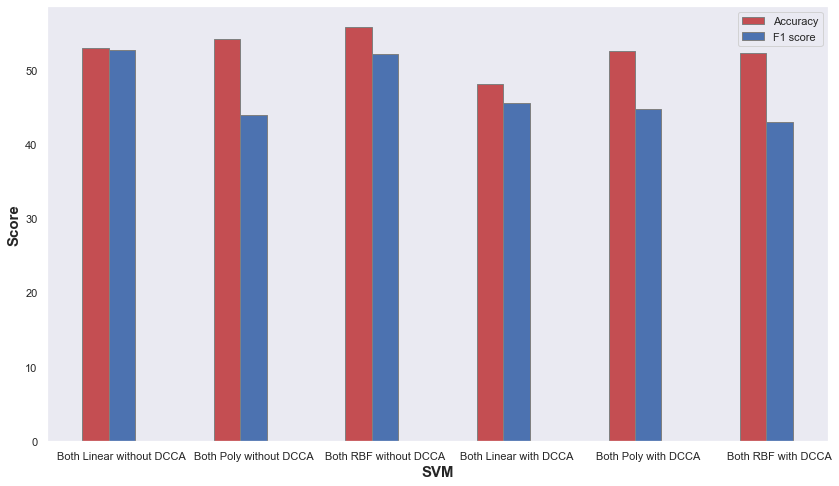

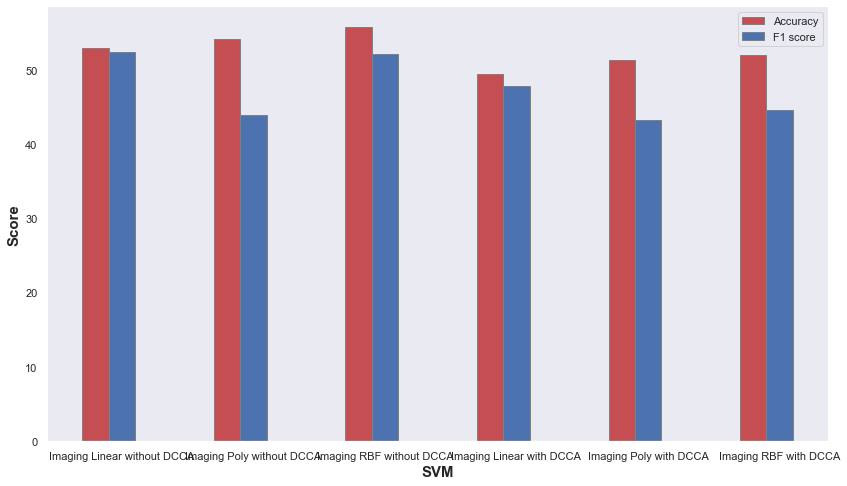

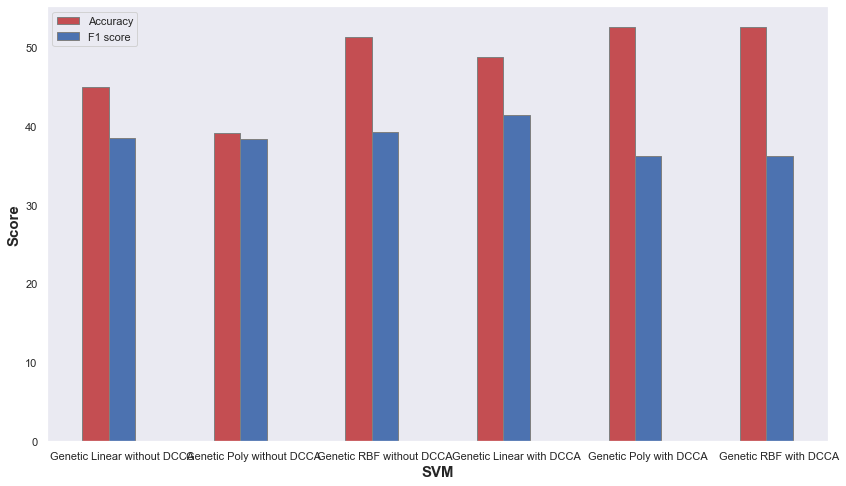

In [137]:
barplot_scores(Accuracies[0:6], F1s[0:6], 
               ['Both Linear without DCCA', 'Both Poly without DCCA', 'Both RBF without DCCA', 'Both Linear with DCCA',
                'Both Poly with DCCA', 'Both RBF with DCCA'])
barplot_scores(Accuracies[6:12], F1s[6:12], 
               ['Imaging Linear without DCCA', 'Imaging Poly without DCCA', 'Imaging RBF without DCCA',
                'Imaging Linear with DCCA', 'Imaging Poly with DCCA', 'Imaging RBF with DCCA'])
barplot_scores(Accuracies[12:18], F1s[12:18], 
               ['Genetic Linear without DCCA', 'Genetic Poly without DCCA', 'Genetic RBF without DCCA', 
                'Genetic Linear with DCCA','Genetic Poly with DCCA', 'Genetic RBF with DCCA'])

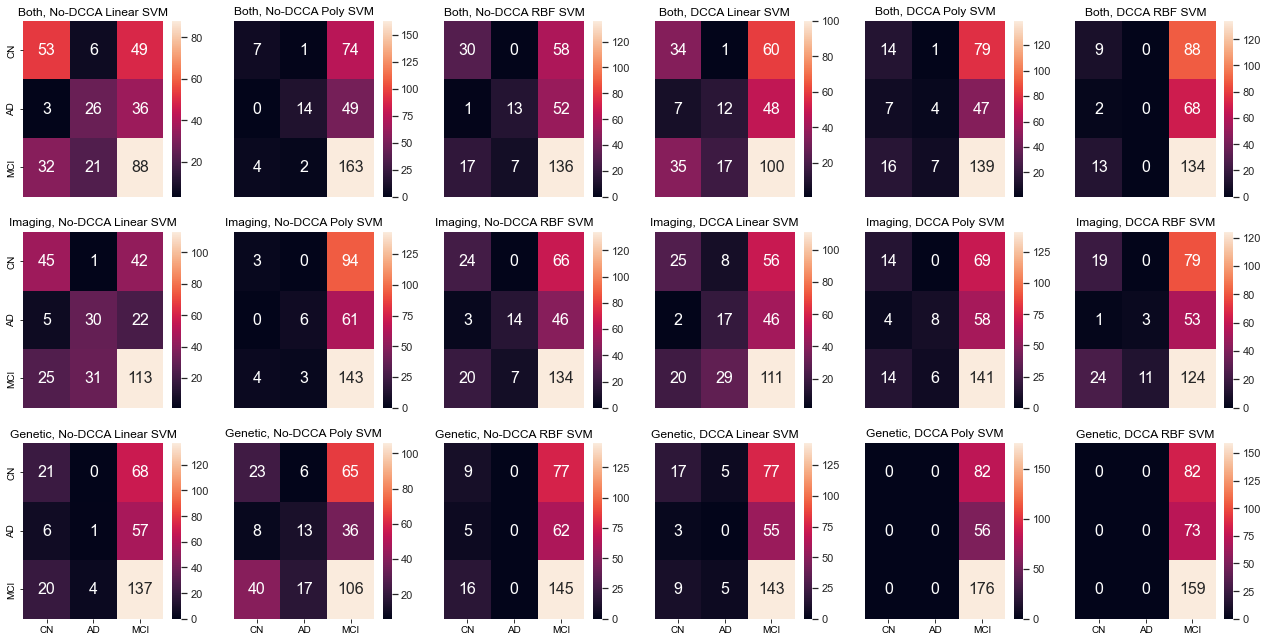

In [9]:
fig, axes = plt.subplots(nrows=3,ncols=6,figsize=(22,11));
sns.set(font_scale=1) # for label size
sns.heatmap(lin_cm, annot=True, annot_kws={"size": 16}, ax = axes[0][0], fmt='g',
           xticklabels = False, yticklabels = ["CN", "AD", "MCI"]).set_title("Both, No-DCCA Linear SVM")
sns.heatmap(poly_cm, annot=True, annot_kws={"size": 16}, ax = axes[0][1], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Both, No-DCCA Poly SVM")
sns.heatmap(rbf_cm, annot=True, annot_kws={"size": 16}, ax = axes[0][2], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Both, No-DCCA RBF SVM")
sns.heatmap(lin_cm_d, annot=True, annot_kws={"size": 16}, ax = axes[0][3], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Both, DCCA Linear SVM")
sns.heatmap(poly_cm_d, annot=True, annot_kws={"size": 16}, ax = axes[0][4], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Both, DCCA Poly SVM")
sns.heatmap(rbf_cm_d, annot=True, annot_kws={"size": 16}, ax = axes[0][5], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Both, DCCA RBF SVM")
###
sns.heatmap(lin_cm_i, annot=True, annot_kws={"size": 16}, ax = axes[1][0], fmt='g',
           xticklabels = False, yticklabels = ["CN", "AD", "MCI"]).set_title("Imaging, No-DCCA Linear SVM")
sns.heatmap(poly_cm_i, annot=True, annot_kws={"size": 16}, ax = axes[1][1], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Imaging, No-DCCA Poly SVM")
sns.heatmap(rbf_cm_i, annot=True, annot_kws={"size": 16}, ax = axes[1][2], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Imaging, No-DCCA RBF SVM")
sns.heatmap(lin_cm_d_i, annot=True, annot_kws={"size": 16}, ax = axes[1][3], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Imaging, DCCA Linear SVM")
sns.heatmap(poly_cm_d_i, annot=True, annot_kws={"size": 16}, ax = axes[1][4], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Imaging, DCCA Poly SVM")
sns.heatmap(rbf_cm_d_i, annot=True, annot_kws={"size": 16}, ax = axes[1][5], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Imaging, DCCA RBF SVM")
###
sns.heatmap(lin_cm_g, annot=True, annot_kws={"size": 16}, ax = axes[2][0], fmt='g',
           xticklabels = ["CN", "AD", "MCI"], yticklabels = ["CN", "AD", "MCI"]).set_title("Genetic, No-DCCA Linear SVM")
sns.heatmap(poly_cm_g, annot=True, annot_kws={"size": 16}, ax = axes[2][1], fmt='g',
           xticklabels = ["CN", "AD", "MCI"], yticklabels = False).set_title("Genetic, No-DCCA Poly SVM")
sns.heatmap(rbf_cm_g, annot=True, annot_kws={"size": 16}, ax = axes[2][2], fmt='g',
           xticklabels = ["CN", "AD", "MCI"], yticklabels = False).set_title("Genetic, No-DCCA RBF SVM")
sns.heatmap(lin_cm_d_g, annot=True, annot_kws={"size": 16}, ax = axes[2][3], fmt='g',
           xticklabels = ["CN", "AD", "MCI"], yticklabels = False).set_title("Genetic, DCCA Linear SVM")
sns.heatmap(poly_cm_d_g, annot=True, annot_kws={"size": 16}, ax = axes[2][4], fmt='g',
           xticklabels = ["CN", "AD", "MCI"], yticklabels = False).set_title("Genetic, DCCA Poly SVM")
sns.heatmap(rbf_cm_d_g, annot=True, annot_kws={"size": 16}, ax = axes[2][5], fmt='g',
           xticklabels = ["CN", "AD", "MCI"], yticklabels = False).set_title("Genetic, DCCA RBF SVM")
plt.show()


### Perform Classification using kNN:

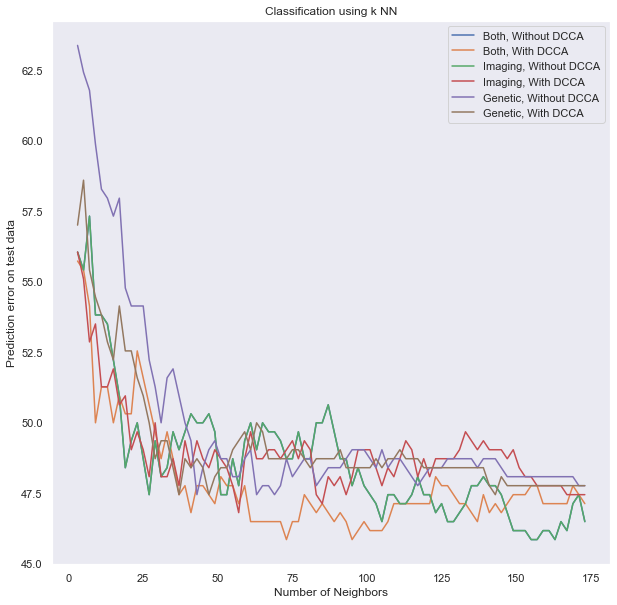

In [10]:
accs = []
accs_d = []
accs_i = []
accs_d_i = []
accs_g = []
accs_d_g = []

neighbors = [x for x in range(3,175,2)]
for nn in neighbors:
    
    knn = KNeighborsClassifier(n_neighbors=nn)
    ############################################################################  on all data (without DCCA):
    # Get the values that interest us:
    X = lr_data[MRI_columns + genetic_columns]
    Y = lr_data["Diagnosis_nearest_2.0_cat"]
    # Perform train-test split:
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.80, shuffle=False)
    # Train:
    knn.fit(X_train, Y_train)
    # Predict:
    acc = knn.score(X_test, Y_test)
    accs.append(100 - acc*100)
    
    knn = KNeighborsClassifier(n_neighbors=nn)
    ############################################################################ on all data (with DCCA):
    # Get the values that interest us:
    X_d = dcca_data[genetic_labels + imaging_labels]
    Y_d = dcca_data["Diagnosis_nearest_2.0_cat"]
    # Perform train-test split:
    X_train_d, X_test_d, Y_train_d, Y_test_d = train_test_split(X_d, Y_d, train_size=0.80, shuffle=False)
    # Train:
    knn.fit(X_train_d, Y_train_d)
    # Predict:
    acc_d = knn.score(X_test_d, Y_test_d)
    accs_d.append(100 - acc_d*100)
    
    knn = KNeighborsClassifier(n_neighbors=nn)   
    ############################################################################  on imaging data (without DCCA):
    # Get the values that interest us:
    X = lr_data[MRI_columns]
    Y = lr_data["Diagnosis_nearest_2.0_cat"]
    # Perform train-test split:
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.80, shuffle=False)
    # Train:
    knn.fit(X_train, Y_train)
    # Predict:
    acc = knn.score(X_test, Y_test)
    accs_i.append(100 - acc*100)
      
    knn = KNeighborsClassifier(n_neighbors=nn)
    ############################################################################ on imaging data (with DCCA):
    # Get the values that interest us:
    X_d = dcca_data[imaging_labels]
    Y_d = dcca_data["Diagnosis_nearest_2.0_cat"]
    # Perform train-test split:
    X_train_d, X_test_d, Y_train_d, Y_test_d = train_test_split(X_d, Y_d, train_size=0.80, shuffle=False)
    # Train:
    knn.fit(X_train_d, Y_train_d)
    # Predict:
    acc_d = knn.score(X_test_d, Y_test_d)
    accs_d_i.append(100 - acc_d*100)
    
    knn = KNeighborsClassifier(n_neighbors=nn)
    ############################################################################  on genetic data (without DCCA):
    # Get the values that interest us:
    X = lr_data[genetic_columns]
    Y = lr_data["Diagnosis_nearest_2.0_cat"]
    # Perform train-test split:
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.80, shuffle=False)
    # Train:
    knn.fit(X_train, Y_train)
    # Predict:
    acc = knn.score(X_test, Y_test)
    accs_g.append(100 - acc*100)

    knn = KNeighborsClassifier(n_neighbors=nn)   
    ############################################################################ on genetic data (with DCCA):
    # Get the values that interest us:
    X_d = dcca_data[genetic_labels]
    Y_d = dcca_data["Diagnosis_nearest_2.0_cat"]
    # Perform train-test split:
    X_train_d, X_test_d, Y_train_d, Y_test_d = train_test_split(X_d, Y_d, train_size=0.80, shuffle=False)
    # Train:
    knn.fit(X_train_d, Y_train_d)
    # Predict:
    acc_d = knn.score(X_test_d, Y_test_d)
    accs_d_g.append(100 - acc_d*100)


plt.figure(figsize=(10,10))
plt.plot(neighbors, accs, label="Both, Without DCCA")
plt.plot(neighbors, accs_d, label="Both, With DCCA")
plt.plot(neighbors, accs_i, label="Imaging, Without DCCA")
plt.plot(neighbors, accs_d_i, label="Imaging, With DCCA")
plt.plot(neighbors, accs_g, label="Genetic, Without DCCA")
plt.plot(neighbors, accs_d_g, label="Genetic, With DCCA")
plt.grid()
plt.legend()
plt.title("Classification using k NN")
plt.ylabel("Prediction error on test data")
plt.xlabel("Number of Neighbors")
plt.show()

In [11]:
for i in range(len(neighbors)):
    print(round(accs[i], 1) , " ", round(accs_i[i],1))

56.1   56.1
55.4   55.4
57.3   57.3
53.8   53.8
53.8   53.8
53.5   53.5
52.2   52.2
51.0   51.0
48.4   48.4
49.4   49.4
50.0   50.0
48.7   48.7
47.5   47.5
49.4   49.4
48.1   48.1
48.4   48.4
49.7   49.7
49.0   49.0
49.7   49.7
50.3   50.3
50.0   50.0
50.0   50.0
50.3   50.3
49.7   49.7
47.5   47.5
47.5   47.5
48.7   48.7
47.8   47.8
49.4   49.4
50.0   50.0
49.0   49.0
50.0   50.0
49.7   49.7
49.7   49.7
49.4   49.4
48.7   48.7
48.7   48.7
49.7   49.7
48.7   48.7
48.7   48.7
50.0   50.0
50.0   50.0
50.6   50.6
49.7   49.7
48.7   48.7
48.7   48.7
47.8   47.8
48.4   48.4
47.8   47.8
47.5   47.5
47.1   47.1
46.5   46.5
47.5   47.5
47.5   47.5
47.1   47.1
47.1   47.1
47.5   47.5
48.1   48.1
47.5   47.5
47.5   47.5
46.8   46.8
47.1   47.1
46.5   46.5
46.5   46.5
46.8   46.8
47.1   47.1
47.8   47.8
47.8   47.8
48.1   48.1
47.8   47.8
47.8   47.8
47.5   47.5
46.8   46.8
46.2   46.2
46.2   46.2
46.2   46.2
45.9   45.9
45.9   45.9
46.2   46.2
46.2   46.2
45.9   45.9
46.5   46.5
46.2   46.2
47.1

### Perform Classification using Decision Trees:

In [12]:
print("################################################################################### Both:")
clf = DecisionTreeClassifier()
X , Y = lr_data[MRI_columns + genetic_columns], lr_data["Diagnosis_nearest_2.0_cat"]
acc_untrained = cross_val_score(clf, X,Y, cv=10)

X , Y = dcca_data[imaging_labels + genetic_labels], dcca_data["Diagnosis_nearest_2.0_cat"]
acc_trained = cross_val_score(clf, X,Y, cv=10)

print("no-DCCA trained Accuracy: ", round(np.mean(acc_untrained)*100,3))
print("DCCA Trained Accuracy:   ", round(np.mean(acc_trained)*100,3))
print("################################################################################### Imaging only:")
clf = DecisionTreeClassifier()
X , Y = lr_data[MRI_columns], lr_data["Diagnosis_nearest_2.0_cat"]
acc_untrained = cross_val_score(clf, X,Y, cv=10)

X , Y = dcca_data[imaging_labels], dcca_data["Diagnosis_nearest_2.0_cat"]
acc_trained = cross_val_score(clf, X,Y, cv=10)

print("no-DCCA trained Accuracy: ", round(np.mean(acc_untrained)*100,3))
print("DCCA Trained Accuracy:   ", round(np.mean(acc_trained)*100,3))
print("################################################################################### Genetic only:")
clf = DecisionTreeClassifier()
X , Y = lr_data[genetic_columns], lr_data["Diagnosis_nearest_2.0_cat"]
acc_untrained = cross_val_score(clf, X,Y, cv=10)

X , Y = dcca_data[genetic_labels], dcca_data["Diagnosis_nearest_2.0_cat"]
acc_trained = cross_val_score(clf, X,Y, cv=10)

print("no-DCCA trained Accuracy: ", round(np.mean(acc_untrained)*100,3))
print("DCCA Trained Accuracy:   ", round(np.mean(acc_trained)*100,3))

################################################################################### Both:
no-DCCA trained Accuracy:  49.072
DCCA Trained Accuracy:    40.337
################################################################################### Imaging only:
no-DCCA trained Accuracy:  48.753
DCCA Trained Accuracy:    41.161
################################################################################### Genetic only:
no-DCCA trained Accuracy:  41.477
DCCA Trained Accuracy:    37.841


### Perform Classification using a Neural Network:

In [158]:
import torch.nn as nn

class NNclassifier(nn.Module):
    def __init__(self, layers, input_size, output_size):
        super().__init__()
        layers = [input_size] + layers
        # Create the NN layers, based on the sizes given:
        network_layers = []
        for i in range(len(layers) - 1):

            # if the layer isn't the last layer:
            if i != len(layers) - 2:
                size = layers[i]
                next_layer_size = layers[i+1]
                
                layer = nn.Sequential(
                    nn.Linear(size, next_layer_size),
                    nn.ReLU(),
                    nn.BatchNorm1d(next_layer_size)
                )
                
                network_layers.append(layer)
                
                
            # if the layer is the last layer:    
            else:
                size = layers[i]
                next_layer_size = output_size
                
                layer = nn.Sequential(
                    nn.Linear(size, next_layer_size),
                    nn.LogSoftmax(),   # Using logSoftmax for the loss criterion.
                    nn.BatchNorm1d(next_layer_size)
                )
                
                network_layers.append(layer)
            
            self.layers = nn.ModuleList(network_layers)    
            
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


    
def Train_NN(net, X_train, Y_train, epochs, batch_size, no_print=False):
    # Using Negative Log-Likelihood Loss Function because it's a multi-class classification problem
    criterion = nn.NLLLoss()
    # Stochastic Gradient Descent with momentum:
    optimizer = optim.SGD(net.parameters(), lr=0.002, momentum=0.9)
    
    # Get the appropriate device for calculations:
    if torch.cuda.is_available():
        device = torch.device('gpu')
    else:
        device = torch.device('cpu')
    # Get the data size:    
    data_size = X_train.shape[0]
    
    # Convert the dataset to tensor and cast them to device:
    X_train.to(device)
    X_train = X_train.type(torch.LongTensor)
    Y_train.to(device)
    Y_train = Y_train.type(torch.LongTensor)
    losses_ = []
    # Train the NN:
    for epoch in range(epochs):  # loop over the dataset multiple times
        epoch_start_time = time.time()
#         TODO: CREATE BATCHING SYSTEM!!!
        # Create a set of IDs for the batch sample to train on:
        batch_idxs = list(BatchSampler(RandomSampler(range(data_size)), batch_size=batch_size, drop_last=False))
        losses = []
        # Train on each batch:
        for batch_idx in batch_idxs:
            # zero the parameter gradients
            optimizer.zero_grad()

            # get the inputs
            inputs, labels = X_train[batch_idx,:], Y_train[batch_idx]

            # forward + backward + optimize
            outputs = net(inputs.float())
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        # Log the time it took for the epoch to train:
        epoch_time = time.time() - epoch_start_time
        losses_.append(losses)
        if (epoch + 1 )% 250 == 0:
            if no_print==False:
                print("Epoch ",str(epoch + 1)," training duration: ", round(epoch_time, 4), ". Loss: ", np.mean(losses))
    print('Finished Training')
    return losses_
    

def Test_NN(net, X_test, Y_test):
    correct = 0
    total = 0
    
    # Get the appropriate device for calculations:
    if torch.cuda.is_available():
        device = torch.device('gpu')
    else:
        device = torch.device('cpu')
    # Convert the dataset to tensor and cast them to device:
    X_test.to(device)
    Y_test.to(device)
    
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        inputs, labels = X_test, Y_test
        # calculate outputs by running inputs through the network
        outputs = net(inputs.float())
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

#     print('Accuracy of the network : %d %%' % (100 * correct / total))
    return (100 * correct / total)

def convert_split_dataset(X,Y):
    # Convert the numpy or pandas DF into torch tensors:
    if type(X) == pd.core.frame.DataFrame:
        X = torch.tensor(X.values.astype(np.float32))
    elif type(X) == np.ndarray:
        X = torch.from_numpy(X)
    
    if type(Y) == pd.core.series.Series:
        Y = torch.tensor(Y.values.astype(np.float32))
    elif type(Y) == np.ndarray:
        Y = torch.from_numpy(Y)

    # Split the dataset:
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.80, shuffle=False)
    return X_train, Y_train, X_test,  Y_test

In [166]:
no_print = True
layers = [512,1024,512]
epochs = 5000
batch_size = 100

print("################################################################################### Both:")
X , Y = lr_data[MRI_columns + genetic_columns], lr_data["Diagnosis_nearest_2.0_cat"]
X_train, Y_train, X_test, Y_test = convert_split_dataset(X,Y)
nn_clf_both = NNclassifier(layers,len(MRI_columns) + len(genetic_columns), 3)
losses_1 = Train_NN(nn_clf_both, X_train, Y_train, epochs, batch_size, no_print)
acc = Test_NN(nn_clf_both, X_test, Y_test)
print('Accuracy (No DCCA) : %d %%' %acc)

X , Y = dcca_data[imaging_labels + genetic_labels], dcca_data["Diagnosis_nearest_2.0_cat"]
X_train, Y_train, X_test, Y_test = convert_split_dataset(X,Y)
nn_clf_both_d = NNclassifier(layers,len(imaging_labels) + len(genetic_labels), 3)
losses_2 = Train_NN(nn_clf_both_d, X_train, Y_train, epochs, batch_size, no_print)
acc = Test_NN(nn_clf_both_d, X_test, Y_test)
print('Accuracy (DCCA) : %d %%' %acc)

print("################################################################################### Imaging only:")
X , Y = lr_data[MRI_columns], lr_data["Diagnosis_nearest_2.0_cat"]
X_train, Y_train, X_test, Y_test = convert_split_dataset(X,Y)
nn_clf_both_i = NNclassifier(layers,len(MRI_columns), 3)
losses_3 = Train_NN(nn_clf_both_i, X_train, Y_train, epochs, batch_size, no_print)
acc = Test_NN(nn_clf_both_i, X_test, Y_test)
print('Accuracy (No DCCA) : %d %%' %acc)

X , Y = dcca_data[imaging_labels], dcca_data["Diagnosis_nearest_2.0_cat"]
X_train, Y_train, X_test, Y_test = convert_split_dataset(X,Y)
nn_clf_both_i_d = NNclassifier(layers,len(imaging_labels), 3)
losses_4 = Train_NN(nn_clf_both_i_d, X_train, Y_train, epochs, batch_size, no_print)
acc = Test_NN(nn_clf_both_i_d, X_test, Y_test)
print('Accuracy (DCCA) : %d %%' %acc)

print("################################################################################### Genetic only:")
X , Y = lr_data[genetic_columns], lr_data["Diagnosis_nearest_2.0_cat"]
X_train, Y_train, X_test, Y_test = convert_split_dataset(X,Y)
nn_clf_both_g = NNclassifier(layers,len(genetic_columns), 3)
losses_5 = Train_NN(nn_clf_both_g, X_train, Y_train, epochs, batch_size, no_print)
acc = Test_NN(nn_clf_both_g, X_test, Y_test)
print('Accuracy (No DCCA) : %d %%' %acc)

X , Y = dcca_data[genetic_labels], dcca_data["Diagnosis_nearest_2.0_cat"]
X_train, Y_train, X_test, Y_test = convert_split_dataset(X,Y)
nn_clf_both_g_d = NNclassifier(layers,len(genetic_labels), 3)
losses_6 = Train_NN(nn_clf_both_g_d, X_train, Y_train, epochs, batch_size, no_print)
acc = Test_NN(nn_clf_both_g_d, X_test, Y_test)
print('Accuracy (DCCA) : %d %%' %acc)



################################################################################### Both:
Finished Training
Accuracy (No DCCA) : 51 %
Finished Training
Accuracy (DCCA) : 47 %
################################################################################### Imaging only:
Finished Training
Accuracy (No DCCA) : 52 %
Finished Training
Accuracy (DCCA) : 48 %
################################################################################### Genetic only:
Finished Training
Accuracy (No DCCA) : 34 %
Finished Training
Accuracy (DCCA) : 33 %


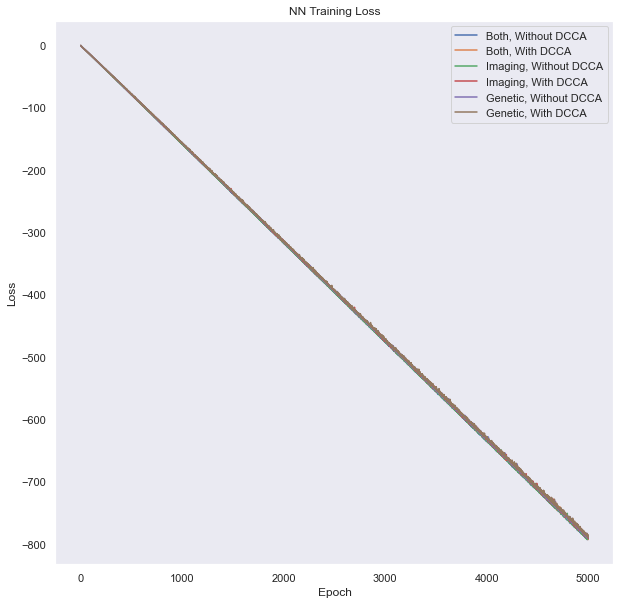

In [167]:
flat_list_1 = [sum(sublist)/len(sublist) for sublist in losses_1]
flat_list_2 = [sum(sublist)/len(sublist) for sublist in losses_2]
flat_list_3 = [sum(sublist)/len(sublist) for sublist in losses_3]
flat_list_4 = [sum(sublist)/len(sublist) for sublist in losses_4]
flat_list_5 = [sum(sublist)/len(sublist) for sublist in losses_5]
flat_list_6 = [sum(sublist)/len(sublist) for sublist in losses_6]


plt.figure(figsize=(10,10))
x = list(range(len(flat_list_1)))
plt.plot(x, flat_list_1, label="Both, Without DCCA")
plt.plot(x, flat_list_2, label="Both, With DCCA")
plt.plot(x, flat_list_3, label="Imaging, Without DCCA")
plt.plot(x, flat_list_4, label="Imaging, With DCCA")
plt.plot(x, flat_list_5, label="Genetic, Without DCCA")
plt.plot(x, flat_list_6, label="Genetic, With DCCA")
plt.grid()
plt.legend()
plt.title("NN Training Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

## Initial Results:

In [16]:
data = {'Model': {0: 'SVM Linear Kernel', 1: 'SVM Poly Kernel', 2: 'SVM RBF Kernel', 3: 'SVM Linear Kernel', 4: 'SVM Poly Kernel', 5: 'SVM RBF Kernel', 6: 'SVM Linear Kernel', 7: 'SVM Poly Kernel', 8: 'SVM RBF Kernel', 9: 'SVM Linear Kernel', 10: 'SVM Poly Kernel', 11: 'SVM RBF Kernel', 12: 'SVM Linear Kernel', 13: 'SVM Poly Kernel', 14: 'SVM RBF Kernel', 15: 'SVM Linear Kernel', 16: 'SVM Poly Kernel', 17: 'SVM RBF Kernel', 18: 'Decision Tree', 19: 'Decision Tree', 20: 'Decision Tree', 21: 'Decision Tree', 22: 'Decision Tree', 23: 'Decision Tree'}, 'Data': {0: 'Imaging + Genetic', 1: 'Imaging + Genetic', 2: 'Imaging + Genetic', 3: 'Imaging + Genetic', 4: 'Imaging + Genetic', 5: 'Imaging + Genetic', 6: 'Imaging', 7: 'Imaging', 8: 'Imaging', 9: 'Imaging', 10: 'Imaging', 11: 'Imaging', 12: 'Genetic', 13: 'Genetic', 14: 'Genetic', 15: 'Genetic', 16: 'Genetic', 17: 'Genetic', 18: 'Imaging + Genetic', 19: 'Imaging + Genetic', 20: 'Imaging', 21: 'Imaging', 22: 'Genetic', 23: 'Genetic'}, 'DCCA / No DCCA': {0: 'No DCCA', 1: 'No DCCA', 2: 'No DCCA', 3: 'DCCA', 4: 'DCCA', 5: 'DCCA', 6: 'No DCCA', 7: 'No DCCA', 8: 'No DCCA', 9: 'DCCA', 10: 'DCCA', 11: 'DCCA', 12: 'No DCCA', 13: 'No DCCA', 14: 'No DCCA', 15: 'DCCA', 16: 'DCCA', 17: 'DCCA', 18: 'No DCCA', 19: 'DCCA', 20: 'No DCCA', 21: 'DCCA', 22: 'No DCCA', 23: 'DCCA'}, 'run 1': {0: 57.64, 1: 58.6, 2: 55.73, 3: 50.32, 4: 46.18, 5: 49.36, 6: 53.18, 7: 51.27, 8: 53.82, 9: 50.0, 10: 50.0, 11: 50.32, 12: 48.73, 13: 44.59, 14: 49.36, 15: 53.5, 16: 50.64, 17: 53.5, 18: 49.0, 19: 39.94, 20: 51.05, 21: 39.31, 22: 40.84, 23: 39.18}, 'run 2': {0: 54.14, 1: 50.0, 2: 54.78, 3: 50.96, 4: 49.04, 5: 49.68, 6: 54.14, 7: 51.27, 8: 53.82, 9: 56.06, 10: 51.59, 11: 52.55, 12: 47.45, 13: 45.22, 14: 47.5, 15: 49.68, 16: 53.18, 17: 54.46, 18: 48.312, 19: 39.628, 20: 49.714, 21: 40.01, 22: 40.9, 23: 38.1}, 'run 3': {0: 59.87, 1: 52.23, 2: 56.37, 3: 49.04, 4: 49.36, 5: 51.27, 6: 55.41, 7: 46.82, 8: 57.32, 9: 49.68, 10: 49.68, 11: 51.27, 12: 50.32, 13: 48.73, 14: 49.36, 15: 52.55, 16: 48.73, 17: 47.13, 18: 47.28, 19: 40.33, 20: 49.77, 21: 39.82, 22: 40.84, 23: 39.97}, 'run 4': {0: 55.1, 1: 49.04, 2: 57.64, 3: 51.59, 4: 46.82, 5: 50.32, 6: 54.78, 7: 52.55, 8: 54.46, 9: 49.89, 10: 52.5, 11: 54.46, 12: 50.0, 13: 50.96, 14: 50.64, 15: 53.18, 16: 42.04, 17: 47.45, 18: 48.37, 19: 39.82, 20: 48.05, 21: 40.14, 22: 40.27, 23: 37.59}, 'run 5': {0: 51.91, 1: 49.04, 2: 58.6, 3: 50.0, 4: 50.64, 5: 49.04, 6: 54.46, 7: 50.64, 8: 54.18, 9: 46.5, 10: 43.82, 11: 51.59, 12: 55.41, 13: 45.22, 14: 48.73, 15: 49.04, 16: 50.32, 17: 49.68, 18: 48.37, 19: 39.94, 20: 50.09, 21: 40.14, 22: 40.33, 23: 38.09}, 'run 6': {0: 56.05, 1: 52.55, 2: 54.14, 3: 50.32, 4: 49.04, 5: 54.46, 6: 57.32, 7: 54.16, 8: 57.32, 9: 47.77, 10: 54.46, 11: 47.45, 12: 50.96, 13: 44.27, 14: 56.37, 15: 45.22, 16: 50.96, 17: 53.18, 18: 49.01, 19: 39.69, 20: 49.39, 21: 40.59, 22: 40.2, 23: 37.9}, 'run 7': {0: 51.59, 1: 52.87, 2: 49.36, 3: 57.1, 4: 50.64, 5: 56.69, 6: 56.69, 7: 50.96, 8: 50.32, 9: 58.6, 10: 48.73, 11: 53.82, 12: 46.5, 13: 46.82, 14: 51.59, 15: 57.01, 16: 50.64, 17: 53.18, 18: 48.62, 19: 40.39, 20: 48.11, 21: 40.46, 22: 41.22, 23: 39.63}, 'run 8': {0: 58.28, 1: 50.32, 2: 57.64, 3: 53.18, 4: 45.22, 5: 49.68, 6: 62.74, 7: 52.23, 8: 58.6, 9: 52.55, 10: 48.41, 11: 50.96, 12: 49.04, 13: 43.95, 14: 45.22, 15: 50.64, 16: 51.91, 17: 50.0, 18: 48.24, 19: 39.56, 20: 48.75, 21: 39.63, 22: 41.73, 23: 38.99}, 'run 9': {0: 57.96, 1: 54.78, 2: 52.87, 3: 49.04, 4: 48.09, 5: 49.04, 6: 61.46, 7: 49.64, 8: 52.87, 9: 46.82, 10: 47.77, 11: 49.64, 12: 47.45, 13: 44.9, 14: 48.41, 15: 46.82, 16: 53.48, 17: 49.04, 18: 48.81, 19: 39.24, 20: 49.522, 21: 40.71, 22: 40.01, 23: 38.03}, 'run 10': {0: 57.32, 1: 47.77, 2: 56.05, 3: 46.5, 4: 48.73, 5: 48.09, 6: 55.1, 7: 49.04, 8: 53.5, 9: 55.41, 10: 46.5, 11: 50.64, 12: 53.5, 13: 43.31, 14: 48.73, 15: 53.18, 16: 49.68, 17: 53.5, 18: 49.13, 19: 39.62, 20: 49.01, 21: 40.46, 22: 41.22, 23: 37.65}, 'Average Accuracy': {0: 55.986, 1: 51.72, 2: 55.318, 3: 50.805, 4: 48.376, 5: 50.763, 6: 56.528, 7: 50.858, 8: 54.621, 9: 51.328, 10: 49.346, 11: 51.27, 12: 49.936, 13: 45.797, 14: 49.591, 15: 51.082, 16: 50.158, 17: 51.112, 18: 48.5142, 19: 39.8158, 20: 49.3456, 21: 40.127, 22: 40.756, 23: 38.513}}
data = pd.DataFrame.from_dict(data, orient='columns', dtype=None)
data

,Model,Data,DCCA / No DCCA,run 1,run 2,run 3,run 4,run 5,run 6,run 7,run 8,run 9,run 10,Average Accuracy
0,SVM Linear Kernel,Imaging + Genetic,No DCCA,57.64,54.140,59.87,55.10,51.91,56.05,51.59,58.28,57.960,57.32,55.9860
1,SVM Poly Kernel,Imaging + Genetic,No DCCA,58.60,50.000,52.23,49.04,49.04,52.55,52.87,50.32,54.780,47.77,51.7200
2,SVM RBF Kernel,Imaging + Genetic,No DCCA,55.73,54.780,56.37,57.64,58.60,54.14,49.36,57.64,52.870,56.05,55.3180
3,SVM Linear Kernel,Imaging + Genetic,DCCA,50.32,50.960,49.04,51.59,50.00,50.32,57.10,53.18,49.040,46.50,50.8050
4,SVM Poly Kernel,Imaging + Genetic,DCCA,46.18,49.040,49.36,46.82,50.64,49.04,50.64,45.22,48.090,48.73,48.3760
5,SVM RBF Kernel,Imaging + Genetic,DCCA,49.36,49.680,51.27,50.32,49.04,54.46,56.69,49.68,49.040,48.09,50.7630
6,SVM Linear Kernel,Imaging,No DCCA,53.18,54.140,55.41,54.78,54.46,57.32,56.69,62.74,61.460,55.10,56.5280
7,SVM Poly Kernel,Imaging,No DCCA,51.27,51.270,46.82,52.55,50.64,54.16,50.96,52.23,49.640,49.04,50.8580
8,SVM RBF Kernel,Imaging,No DCCA,53.82,53.820,57.32,54.46,54.18,57.32,50.32,58.60,52.870,53.50,54.6210
9,SVM Linear Kernel,Imaging,DCCA,50.00,56.060,49.68,49.89,46.50,47.77,58.60,52.55,46.820,55.41,51.3280


## Try with balancing & scaling:

In [140]:
# Read data:
lr_data = pd.read_pickle("./DATA/Linearly_Transformed_Unique_Dataset.pkl")

# Scale the data:
scaler = preprocessing.StandardScaler()
lr_data_scaled = scaler.fit_transform(lr_data[MRI_columns + genetic_columns])
lr_data[MRI_columns + genetic_columns] = lr_data_scaled

# Balance the data through Undersampling:
rus = RandomUnderSampler()
X = lr_data.drop('Diagnosis_nearest_2.0_cat', axis = 1)
Y = lr_data['Diagnosis_nearest_2.0_cat']
c = list(lr_data.columns)
c.remove('Diagnosis_nearest_2.0_cat')

X_res, Y_res = rus.fit_resample(X,Y)
print(Y_res.value_counts())


lr_data = pd.DataFrame(X_res,columns = c)
lr_data['Diagnosis_nearest_2.0_cat'] = Y_res
lr_data.sort_values('PTID', inplace=True,ignore_index=True)
print(lr_data.shape)
lr_data.head(10)

0    309
1    309
2    309
Name: Diagnosis_nearest_2.0_cat, dtype: int64
(927, 208)


/var/folders/c9/121x4df174j1dqk40d8dkzvw0000gn/T/ipykernel_16922/1936122480.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  lr_data['Diagnosis_nearest_2.0_cat'] = Y_res


,PTID,Date,Age,Sex,DLICV_baseline,APOE4_Alleles,APOE_Genotype,Diagnosis_nearest_2.0,MUSE_Volume_4,MUSE_Volume_11,...,rs111278892,rs3752246,rs4147929,rs41289512,rs3865444,rs6024870,rs6014724,rs7274581,rs429358,Diagnosis_nearest_2.0_cat
0,002_S_0295,2006-04-18,84.742466,0,1485405.375,1.0,E3/E4,CN,-0.908924,-0.858791,...,1.231858,1.180656,1.161067,-0.441106,-0.919802,-0.432913,-0.442132,-0.438696,0.646235,0
1,002_S_0559,2006-05-23,79.223288,0,1570479.625,1.0,E3/E4,CN,0.098174,2.035702,...,-0.644062,-0.651114,-0.654693,-0.441106,0.636710,-0.432913,-0.442132,-0.438696,-0.853988,0
2,002_S_0619,2006-06-01,77.447945,0,1859348.250,2.0,E4/E4,Dementia,3.918745,1.250390,...,-0.644062,-0.651114,-0.654693,2.187082,0.636710,-0.432913,-0.442132,-0.438696,2.146458,1
3,002_S_0685,2006-07-06,89.561644,1,1372862.125,0.0,E3/E3,CN,0.931389,-0.391114,...,1.231858,1.180656,1.161067,-0.441106,-0.919802,-0.432913,-0.442132,-0.438696,-0.853988,0
4,002_S_0729,2006-07-17,65.056164,1,1166961.750,1.0,E3/E4,MCI,0.173361,1.211706,...,-0.644062,-0.651114,-0.654693,2.187082,0.636710,-0.432913,-0.442132,-0.438696,0.646235,2
5,002_S_0816,2006-08-30,70.767123,0,1444128.125,2.0,E4/E4,Dementia,-0.443184,-0.286846,...,-0.644062,-0.651114,-0.654693,-0.441106,0.636710,-0.432913,-0.442132,-0.438696,2.146458,1
6,002_S_0938,2006-10-05,82.167123,1,1309685.000,0.0,E3/E3,Dementia,0.052365,-1.046195,...,-0.644062,1.180656,1.161067,-0.441106,0.636710,-0.432913,-0.442132,-0.438696,-0.853988,1
7,002_S_0954,2006-10-10,69.198630,1,1075661.500,1.0,E3/E4,MCI,-0.343188,2.516193,...,3.107777,1.180656,1.161067,-0.441106,0.636710,-0.432913,-0.442132,-0.438696,0.646235,2
8,002_S_0955,2006-10-11,78.161644,1,1363607.000,1.0,E3/E4,Dementia,1.418155,-0.578068,...,1.231858,-0.651114,-0.654693,-0.441106,0.636710,-0.432913,-0.442132,-0.438696,0.646235,1
9,002_S_1018,2006-11-29,70.658904,1,1355603.000,0.0,E3/E3,Dementia,-0.994375,0.953006,...,1.231858,1.180656,1.161067,-0.441106,-0.919802,-0.432913,-0.442132,-0.438696,-0.853988,1


In [141]:
# Scale the data:
scaler = preprocessing.StandardScaler()
dcca_data_scaled = scaler.fit_transform(dcca_data[imaging_labels + genetic_labels])
dcca_data[imaging_labels + genetic_labels] = dcca_data_scaled

# Balance the data through Undersampling - Use the same indexes as the LR Data:
dcca_data = dcca_data.loc[dcca_data['PTID'].isin(lr_data['PTID'])]

print(dcca_data.shape)
dcca_data.head(10)

(927, 109)


,PTID,Date,Age,Sex,DLICV_baseline,APOE4_Alleles,APOE_Genotype,Diagnosis_nearest_2.0,Diagnosis_nearest_2.0_cat,genetic_component_1,...,imaging_component_41,imaging_component_42,imaging_component_43,imaging_component_44,imaging_component_45,imaging_component_46,imaging_component_47,imaging_component_48,imaging_component_49,imaging_component_50
0,002_S_0295,2006-04-18,84.742466,0,1485405.375,1.0,E3/E4,CN,0,0.239971,...,-0.406224,-0.294464,-1.390996,-0.107520,0.872466,0.066347,-1.170111,1.188624,-1.826829,0.934377
24,002_S_0559,2006-05-23,79.223288,0,1570479.625,1.0,E3/E4,CN,0,0.514009,...,0.137124,0.136691,0.829500,0.513861,1.798133,0.059092,1.336856,0.774671,-0.286866,0.847806
31,002_S_0619,2006-06-01,77.447945,0,1859348.250,2.0,E4/E4,Dementia,1,0.446369,...,-0.229673,0.745673,1.091580,-1.031309,-1.325844,-0.035906,-1.114655,-0.459806,-1.636098,0.178381
36,002_S_0685,2006-07-06,89.561644,1,1372862.125,0.0,E3/E3,CN,0,-0.859376,...,0.728380,0.545770,-0.384258,1.349728,-0.680168,1.325390,-0.628780,0.403546,0.830311,2.166270
45,002_S_0729,2006-07-17,65.056164,1,1166961.750,1.0,E3/E4,MCI,2,-0.600106,...,-0.427532,1.456800,-1.145434,-1.130741,0.867999,-0.566044,-0.311592,1.755273,0.192166,-0.378896
64,002_S_0816,2006-08-30,70.767123,0,1444128.125,2.0,E4/E4,Dementia,1,0.968991,...,0.888122,0.933695,0.118278,-0.864758,-0.529869,2.133768,-0.246656,-0.568852,1.095003,1.303417
69,002_S_0938,2006-10-05,82.167123,1,1309685.000,0.0,E3/E3,Dementia,1,-1.288293,...,-1.638524,1.371855,-0.674994,0.420072,1.163166,-1.193839,2.431108,1.727957,0.520849,0.359889
74,002_S_0954,2006-10-10,69.198630,1,1075661.500,1.0,E3/E4,MCI,2,1.900294,...,-0.640620,0.604062,-1.653799,2.290661,0.214589,0.822982,0.593344,0.328649,0.912162,0.737328
81,002_S_0955,2006-10-11,78.161644,1,1363607.000,1.0,E3/E4,Dementia,1,-0.151468,...,0.368906,0.730713,-1.799513,0.345784,-0.117083,-0.400543,0.342786,2.055909,0.957337,1.517382
84,002_S_1018,2006-11-29,70.658904,1,1355603.000,0.0,E3/E3,Dementia,1,1.127673,...,-0.127192,-1.120336,1.140932,1.022317,-0.987983,2.127481,-0.666306,-0.095933,0.045984,0.794772


### Perform Classification using SVMs:

In [142]:
Accuracies = []
F1s = []
# LinearSVC: one-vs-the-rest scheme.
# SVC: one-vs-one scheme.

##############################################################################  IMAGING + GENETIC without DCCA:
print("#################### IMAGING + GENETIC: ####################")
# Get the values that interest us:
X = lr_data[MRI_columns + genetic_columns]
Y = lr_data["Diagnosis_nearest_2.0_cat"]

# Create 3 separate kernels for experimentation (increase max_iter because of warning):
lin_accuracy, lin_f1, lin_cm = perform_svm(X,Y, kern='linear')
poly_accuracy, poly_f1, poly_cm = perform_svm(X,Y,kern='poly')
rbf_accuracy, rbf_f1, rbf_cm = perform_svm(X,Y,kern='rbf')

Accuracies += lin_accuracy, poly_accuracy, rbf_accuracy
F1s += lin_f1, poly_f1, rbf_f1

############################################################################## IMAGING + GENETIC with DCCA:
print("#################### IMAGING + GENETIC DCCA: ####################")
# Get the values that interest us:
X = dcca_data[genetic_labels + imaging_labels]
Y = dcca_data["Diagnosis_nearest_2.0_cat"]

# Create 3 separate kernels for experimentation (increase max_iter because of warning):
lin_accuracy, lin_f1, lin_cm_d = perform_svm(X,Y, kern='linear')
poly_accuracy, poly_f1, poly_cm_d = perform_svm(X,Y,kern='poly')
rbf_accuracy, rbf_f1, rbf_cm_d = perform_svm(X,Y,kern='rbf')

Accuracies += lin_accuracy, poly_accuracy, rbf_accuracy
F1s += lin_f1, poly_f1, rbf_f1

##############################################################################  IMAGING ONLY without DCCA:
print("#################### IMAGING: ####################")
# Get the values that interest us:
X = lr_data[MRI_columns]
Y = lr_data["Diagnosis_nearest_2.0_cat"]

# Create 3 separate kernels for experimentation (increase max_iter because of warning):
lin_accuracy, lin_f1, lin_cm_i = perform_svm(X,Y, kern='linear')
poly_accuracy, poly_f1, poly_cm_i = perform_svm(X,Y,kern='poly')
rbf_accuracy, rbf_f1, rbf_cm_i = perform_svm(X,Y,kern='rbf')

Accuracies += lin_accuracy, poly_accuracy, rbf_accuracy
F1s += lin_f1, poly_f1, rbf_f1

############################################################################## IMAGING ONLY with DCCA:
print("#################### IMAGING DCCA: ####################")
# Get the values that interest us:
X = dcca_data[imaging_labels]
Y = dcca_data["Diagnosis_nearest_2.0_cat"]

# Create 3 separate kernels for experimentation (increase max_iter because of warning):
lin_accuracy, lin_f1, lin_cm_d_i = perform_svm(X,Y, kern='linear')
poly_accuracy, poly_f1, poly_cm_d_i = perform_svm(X,Y,kern='poly')
rbf_accuracy, rbf_f1, rbf_cm_d_i = perform_svm(X,Y,kern='rbf')

Accuracies += lin_accuracy, poly_accuracy, rbf_accuracy
F1s += lin_f1, poly_f1, rbf_f1

##############################################################################  GENETIC ONLY without DCCA:
print("#################### GENETIC: ####################")
# Get the values that interest us:
X = lr_data[genetic_columns]
Y = lr_data["Diagnosis_nearest_2.0_cat"]

# Create 3 separate kernels for experimentation (increase max_iter because of warning):
lin_accuracy, lin_f1, lin_cm_g = perform_svm(X,Y, kern='linear')
poly_accuracy, poly_f1, poly_cm_g = perform_svm(X,Y,kern='poly')
rbf_accuracy, rbf_f1, rbf_cm_g = perform_svm(X,Y,kern='rbf')

Accuracies += lin_accuracy, poly_accuracy, rbf_accuracy
F1s += lin_f1, poly_f1, rbf_f1

############################################################################## GENETIC ONLY with DCCA:
print("#################### GENETIC DCCA: ####################")
# Get the values that interest us:
X = dcca_data[genetic_labels]
Y = dcca_data["Diagnosis_nearest_2.0_cat"]

# Create 3 separate kernels for experimentation (increase max_iter because of warning):
lin_accuracy, lin_f1, lin_cm_d_g = perform_svm(X,Y, kern='linear')
poly_accuracy, poly_f1, poly_cm_d_g = perform_svm(X,Y,kern='poly')
rbf_accuracy, rbf_f1, rbf_cm_d_g = perform_svm(X,Y,kern='rbf')

Accuracies += lin_accuracy, poly_accuracy, rbf_accuracy
F1s += lin_f1, poly_f1, rbf_f1

names = ['Both Linear without DCCA', 'Both Poly without DCCA', 'Both RBF without DCCA', 'Both Linear with DCCA',
         'Both Poly with DCCA', 'Both RBF with DCCA', 'Imaging Linear without DCCA', 'Imaging Poly without DCCA',
         'Imaging RBF without DCCA','Imaging Linear with DCCA', 'Imaging Poly with DCCA', 'Imaging RBF with DCCA',
         'Genetic Linear without DCCA', 'Genetic Poly without DCCA', 'Genetic RBF without DCCA', 'Genetic Linear with DCCA',
         'Genetic Poly with DCCA', 'Genetic RBF with DCCA']

max_acc = np.argmax(Accuracies)
print("Model with max Accuracy: ", names[max_acc], " with an Accuracy score of ", round(max(Accuracies)*100,3))
max_f1 = np.argmax(F1s)
print("Model with max F1 Score: ", names[max_f1], " with an F1 Score of ", round(max(F1s)*100,3))

#################### IMAGING + GENETIC: ####################
Accuracy (linear Kernel):  51.61
F1 (linear Kernel):  51.52
Accuracy (poly Kernel):  44.62
F1 (poly Kernel):  39.61
Accuracy (rbf Kernel):  52.15
F1 (rbf Kernel):  50.72
#################### IMAGING + GENETIC DCCA: ####################
Accuracy (linear Kernel):  42.47
F1 (linear Kernel):  41.73
Accuracy (poly Kernel):  44.62
F1 (poly Kernel):  44.64
Accuracy (rbf Kernel):  44.09
F1 (rbf Kernel):  42.74
#################### IMAGING: ####################
Accuracy (linear Kernel):  49.46
F1 (linear Kernel):  48.58
Accuracy (poly Kernel):  45.70
F1 (poly Kernel):  42.04
Accuracy (rbf Kernel):  54.84
F1 (rbf Kernel):  53.67
#################### IMAGING DCCA: ####################
Accuracy (linear Kernel):  45.70
F1 (linear Kernel):  44.83
Accuracy (poly Kernel):  44.62
F1 (poly Kernel):  44.13
Accuracy (rbf Kernel):  46.24
F1 (rbf Kernel):  43.75
#################### GENETIC: ####################
Accuracy (linear Kernel):  34.41
F1

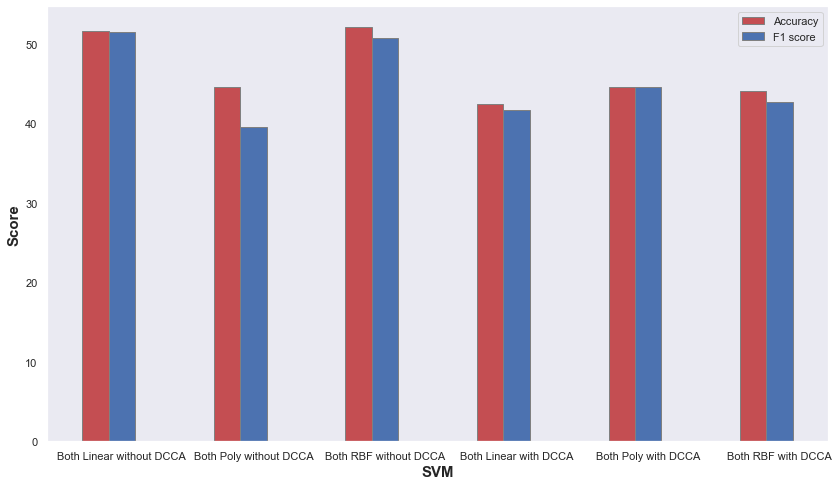

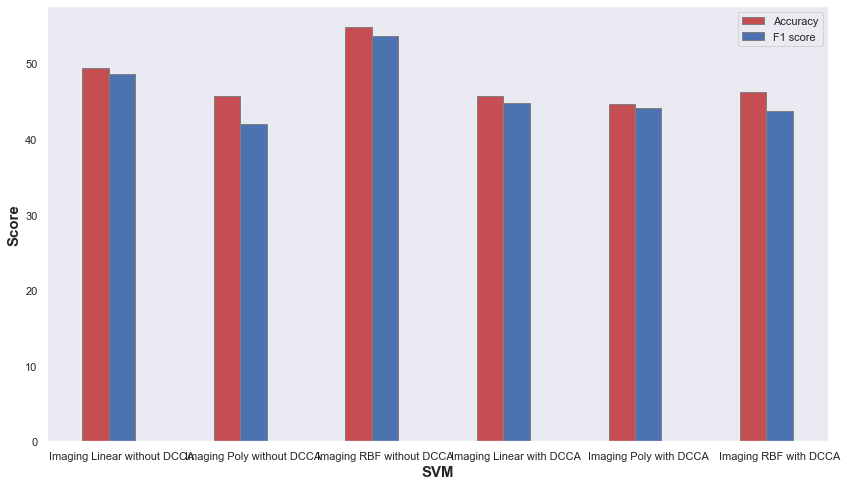

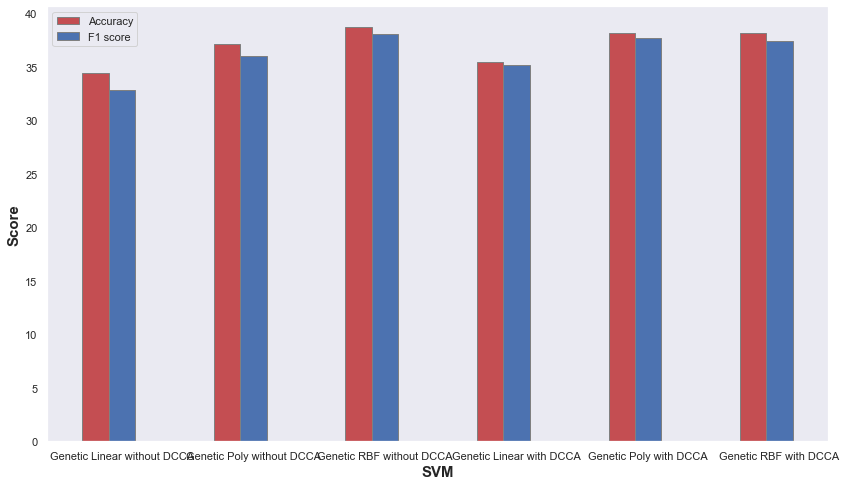

In [143]:
barplot_scores(Accuracies[0:6], F1s[0:6], 
               ['Both Linear without DCCA', 'Both Poly without DCCA', 'Both RBF without DCCA', 'Both Linear with DCCA',
                'Both Poly with DCCA', 'Both RBF with DCCA'])
barplot_scores(Accuracies[6:12], F1s[6:12], 
               ['Imaging Linear without DCCA', 'Imaging Poly without DCCA', 'Imaging RBF without DCCA',
                'Imaging Linear with DCCA', 'Imaging Poly with DCCA', 'Imaging RBF with DCCA'])
barplot_scores(Accuracies[12:18], F1s[12:18], 
               ['Genetic Linear without DCCA', 'Genetic Poly without DCCA', 'Genetic RBF without DCCA', 
                'Genetic Linear with DCCA','Genetic Poly with DCCA', 'Genetic RBF with DCCA'])

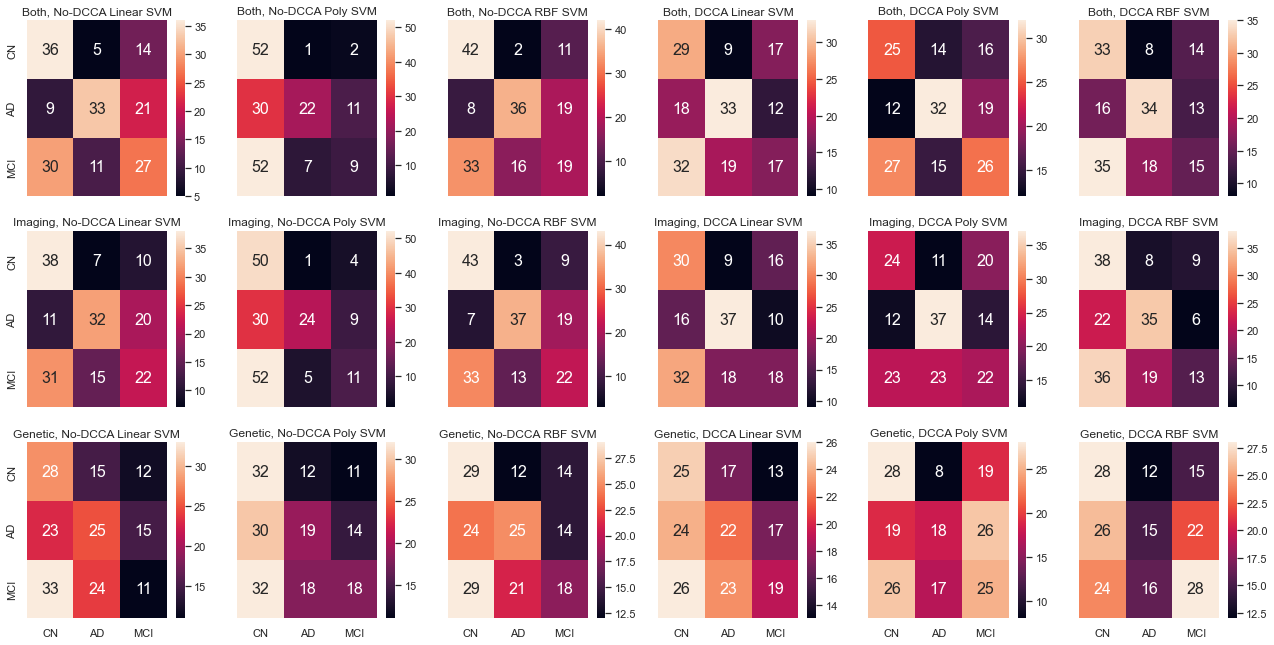

In [144]:
# Test size is 186

fig, axes = plt.subplots(nrows=3,ncols=6,figsize=(22,11));
sns.set(font_scale=1) # for label size
sns.heatmap(lin_cm, annot=True, annot_kws={"size": 16}, ax = axes[0][0], fmt='g',
           xticklabels = False, yticklabels = ["CN", "AD", "MCI"]).set_title("Both, No-DCCA Linear SVM")
sns.heatmap(poly_cm, annot=True, annot_kws={"size": 16}, ax = axes[0][1], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Both, No-DCCA Poly SVM")
sns.heatmap(rbf_cm, annot=True, annot_kws={"size": 16}, ax = axes[0][2], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Both, No-DCCA RBF SVM")
sns.heatmap(lin_cm_d, annot=True, annot_kws={"size": 16}, ax = axes[0][3], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Both, DCCA Linear SVM")
sns.heatmap(poly_cm_d, annot=True, annot_kws={"size": 16}, ax = axes[0][4], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Both, DCCA Poly SVM")
sns.heatmap(rbf_cm_d, annot=True, annot_kws={"size": 16}, ax = axes[0][5], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Both, DCCA RBF SVM")
###
sns.heatmap(lin_cm_i, annot=True, annot_kws={"size": 16}, ax = axes[1][0], fmt='g',
           xticklabels = False, yticklabels = ["CN", "AD", "MCI"]).set_title("Imaging, No-DCCA Linear SVM")
sns.heatmap(poly_cm_i, annot=True, annot_kws={"size": 16}, ax = axes[1][1], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Imaging, No-DCCA Poly SVM")
sns.heatmap(rbf_cm_i, annot=True, annot_kws={"size": 16}, ax = axes[1][2], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Imaging, No-DCCA RBF SVM")
sns.heatmap(lin_cm_d_i, annot=True, annot_kws={"size": 16}, ax = axes[1][3], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Imaging, DCCA Linear SVM")
sns.heatmap(poly_cm_d_i, annot=True, annot_kws={"size": 16}, ax = axes[1][4], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Imaging, DCCA Poly SVM")
sns.heatmap(rbf_cm_d_i, annot=True, annot_kws={"size": 16}, ax = axes[1][5], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Imaging, DCCA RBF SVM")
###
sns.heatmap(lin_cm_g, annot=True, annot_kws={"size": 16}, ax = axes[2][0], fmt='g',
           xticklabels = ["CN", "AD", "MCI"], yticklabels = ["CN", "AD", "MCI"]).set_title("Genetic, No-DCCA Linear SVM")
sns.heatmap(poly_cm_g, annot=True, annot_kws={"size": 16}, ax = axes[2][1], fmt='g',
           xticklabels = ["CN", "AD", "MCI"], yticklabels = False).set_title("Genetic, No-DCCA Poly SVM")
sns.heatmap(rbf_cm_g, annot=True, annot_kws={"size": 16}, ax = axes[2][2], fmt='g',
           xticklabels = ["CN", "AD", "MCI"], yticklabels = False).set_title("Genetic, No-DCCA RBF SVM")
sns.heatmap(lin_cm_d_g, annot=True, annot_kws={"size": 16}, ax = axes[2][3], fmt='g',
           xticklabels = ["CN", "AD", "MCI"], yticklabels = False).set_title("Genetic, DCCA Linear SVM")
sns.heatmap(poly_cm_d_g, annot=True, annot_kws={"size": 16}, ax = axes[2][4], fmt='g',
           xticklabels = ["CN", "AD", "MCI"], yticklabels = False).set_title("Genetic, DCCA Poly SVM")
sns.heatmap(rbf_cm_d_g, annot=True, annot_kws={"size": 16}, ax = axes[2][5], fmt='g',
           xticklabels = ["CN", "AD", "MCI"], yticklabels = False).set_title("Genetic, DCCA RBF SVM")
plt.show()

### Perform Classification using k-NN:

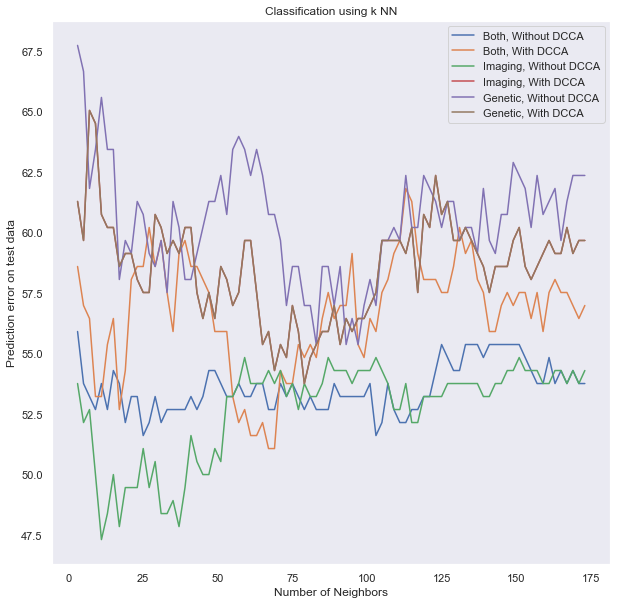

In [145]:
accs = []
accs_d = []
accs_i = []
accs_d_i = []
accs_g = []
accs_d_g = []


neighbors = [x for x in range(3,175,2)]
for nn in neighbors:
    knn = KNeighborsClassifier(n_neighbors=nn)
    
    ##################################################################  on all data (without DCCA):
    # Get the values that interest us:
    X = lr_data[MRI_columns + genetic_columns]
    Y = lr_data["Diagnosis_nearest_2.0_cat"]
    # Perform train-test split:
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.80, shuffle=False)
    # Train:
    knn.fit(X_train, Y_train)
    # Predict:
    acc = knn.score(X_test, Y_test)
    accs.append(100 - acc*100)
    
    ################################################################## on all data (with DCCA):
    # Get the values that interest us:
    X_d = dcca_data[genetic_labels + imaging_labels]
    Y_d = dcca_data["Diagnosis_nearest_2.0_cat"]
    # Perform train-test split:
    X_train_d, X_test_d, Y_train_d, Y_test_d = train_test_split(X_d, Y_d, train_size=0.80, shuffle=False)
    # Train:
    knn.fit(X_train_d, Y_train_d)
    # Predict:
    acc_d = knn.score(X_test_d, Y_test_d)
    accs_d.append(100 - acc_d*100)
    
    ##################################################################  on imaging data (without DCCA):
    # Get the values that interest us:
    X = lr_data[MRI_columns]
    Y = lr_data["Diagnosis_nearest_2.0_cat"]
    # Perform train-test split:
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.80, shuffle=False)
    # Train:
    knn.fit(X_train, Y_train)
    # Predict:
    acc = knn.score(X_test, Y_test)
    accs_i.append(100 - acc*100)
      
    ################################################################## on imaging data (with DCCA):
    # Get the values that interest us:
    X_d = dcca_data[imaging_labels]
    Y_d = dcca_data["Diagnosis_nearest_2.0_cat"]
    # Perform train-test split:
    X_train_d, X_test_d, Y_train_d, Y_test_d = train_test_split(X_d, Y_d, train_size=0.80, shuffle=False)
    # Train:
    knn.fit(X_train_d, Y_train_d)
    # Predict:
    acc_d = knn.score(X_test_d, Y_test_d)
    accs_d_i.append(100 - acc_d*100)
    
    ##################################################################  on genetic data (without DCCA):
    # Get the values that interest us:
    X = lr_data[genetic_columns]
    Y = lr_data["Diagnosis_nearest_2.0_cat"]
    # Perform train-test split:
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.80, shuffle=False)
    # Train:
    knn.fit(X_train, Y_train)
    # Predict:
    acc = knn.score(X_test, Y_test)
    accs_g.append(100 - acc*100)

    ################################################################## on genetic data (with DCCA):
    # Get the values that interest us:
    X_d = dcca_data[genetic_labels]
    Y_d = dcca_data["Diagnosis_nearest_2.0_cat"]
    # Perform train-test split:
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.80, shuffle=False)
    # Train:
    knn.fit(X_train_d, Y_train_d)
    # Predict:
    acc_d = knn.score(X_test_d, Y_test_d)
    accs_d_g.append(100 - acc_d*100)


plt.figure(figsize=(10,10))
plt.plot(neighbors, accs, label="Both, Without DCCA")
plt.plot(neighbors, accs_d, label="Both, With DCCA")
plt.plot(neighbors, accs_i, label="Imaging, Without DCCA")
plt.plot(neighbors, accs_d_i, label="Imaging, With DCCA")
plt.plot(neighbors, accs_g, label="Genetic, Without DCCA")
plt.plot(neighbors, accs_d_g, label="Genetic, With DCCA")
plt.grid()
plt.legend()
plt.title("Classification using k NN")
plt.ylabel("Prediction error on test data")
plt.xlabel("Number of Neighbors")
plt.show()

### Perform Classification using Decision Trees:

In [146]:
print("################################################################################### Both:")
clf = DecisionTreeClassifier()
X , Y = lr_data[MRI_columns + genetic_columns], lr_data["Diagnosis_nearest_2.0_cat"]
acc_untrained = cross_val_score(clf, X,Y, cv=10)

X , Y = dcca_data[imaging_labels + genetic_labels], dcca_data["Diagnosis_nearest_2.0_cat"]
acc_trained = cross_val_score(clf, X,Y, cv=10)

print("no-DCCA trained Accuracy: ", round(np.mean(acc_untrained)*100,3))
print("DCCA Trained Accuracy:   ", round(np.mean(acc_trained)*100,3))
print("################################################################################### Imaging only:")
clf = DecisionTreeClassifier()
X , Y = lr_data[MRI_columns], lr_data["Diagnosis_nearest_2.0_cat"]
acc_untrained = cross_val_score(clf, X,Y, cv=10)

X , Y = dcca_data[imaging_labels], dcca_data["Diagnosis_nearest_2.0_cat"]
acc_trained = cross_val_score(clf, X,Y, cv=10)

print("no-DCCA trained Accuracy: ", round(np.mean(acc_untrained)*100,3))
print("DCCA Trained Accuracy:   ", round(np.mean(acc_trained)*100,3))
print("################################################################################### Genetic only:")
clf = DecisionTreeClassifier()
X , Y = lr_data[genetic_columns], lr_data["Diagnosis_nearest_2.0_cat"]
acc_untrained = cross_val_score(clf, X,Y, cv=10)

X , Y = dcca_data[genetic_labels], dcca_data["Diagnosis_nearest_2.0_cat"]
acc_trained = cross_val_score(clf, X,Y, cv=10)

print("no-DCCA trained Accuracy: ", round(np.mean(acc_untrained)*100,3))
print("DCCA Trained Accuracy:   ", round(np.mean(acc_trained)*100,3))

################################################################################### Both:
no-DCCA trained Accuracy:  51.016
DCCA Trained Accuracy:    37.647
################################################################################### Imaging only:
no-DCCA trained Accuracy:  50.483
DCCA Trained Accuracy:    36.24
################################################################################### Genetic only:
no-DCCA trained Accuracy:  36.138
DCCA Trained Accuracy:    31.81


In [ ]:
no_print = True
layers = [512,1024,512]
epochs = 5000
batch_size = 100

print("################################################################################### Both:")
X , Y = lr_data[MRI_columns + genetic_columns], lr_data["Diagnosis_nearest_2.0_cat"]
X_train, Y_train, X_test, Y_test = convert_split_dataset(X,Y)
nn_clf_both = NNclassifier(layers,len(MRI_columns) + len(genetic_columns), 3)
losses_1 = Train_NN(nn_clf_both, X_train, Y_train, epochs, batch_size, no_print)
acc = Test_NN(nn_clf_both, X_test, Y_test)
print('Accuracy (No DCCA) : %d %%' %acc)

X , Y = dcca_data[imaging_labels + genetic_labels], dcca_data["Diagnosis_nearest_2.0_cat"]
X_train, Y_train, X_test, Y_test = convert_split_dataset(X,Y)
nn_clf_both_d = NNclassifier(layers,len(imaging_labels) + len(genetic_labels), 3)
losses_2 = Train_NN(nn_clf_both_d, X_train, Y_train, epochs, batch_size, no_print)
acc = Test_NN(nn_clf_both_d, X_test, Y_test)
print('Accuracy (DCCA) : %d %%' %acc)

print("################################################################################### Imaging only:")
X , Y = lr_data[MRI_columns], lr_data["Diagnosis_nearest_2.0_cat"]
X_train, Y_train, X_test, Y_test = convert_split_dataset(X,Y)
nn_clf_both_i = NNclassifier(layers,len(MRI_columns), 3)
losses_3 = Train_NN(nn_clf_both_i, X_train, Y_train, epochs, batch_size, no_print)
acc = Test_NN(nn_clf_both_i, X_test, Y_test)
print('Accuracy (No DCCA) : %d %%' %acc)

X , Y = dcca_data[imaging_labels], dcca_data["Diagnosis_nearest_2.0_cat"]
X_train, Y_train, X_test, Y_test = convert_split_dataset(X,Y)
nn_clf_both_i_d = NNclassifier(layers,len(imaging_labels), 3)
losses_4 = Train_NN(nn_clf_both_i_d, X_train, Y_train, epochs, batch_size, no_print)
acc = Test_NN(nn_clf_both_i_d, X_test, Y_test)
print('Accuracy (DCCA) : %d %%' %acc)

print("################################################################################### Genetic only:")
X , Y = lr_data[genetic_columns], lr_data["Diagnosis_nearest_2.0_cat"]
X_train, Y_train, X_test, Y_test = convert_split_dataset(X,Y)
nn_clf_both_g = NNclassifier(layers,len(genetic_columns), 3)
losses_5 = Train_NN(nn_clf_both_g, X_train, Y_train, epochs, batch_size, no_print)
acc = Test_NN(nn_clf_both_g, X_test, Y_test)
print('Accuracy (No DCCA) : %d %%' %acc)

X , Y = dcca_data[genetic_labels], dcca_data["Diagnosis_nearest_2.0_cat"]
X_train, Y_train, X_test, Y_test = convert_split_dataset(X,Y)
nn_clf_both_g_d = NNclassifier(layers,len(genetic_labels), 3)
losses_6 = Train_NN(nn_clf_both_g_d, X_train, Y_train, epochs, batch_size, no_print)
acc = Test_NN(nn_clf_both_g_d, X_test, Y_test)
print('Accuracy (DCCA) : %d %%' %acc)

################################################################################### Both:
Finished Training
Accuracy (No DCCA) : 50 %
Finished Training
Accuracy (DCCA) : 47 %
################################################################################### Imaging only:
Finished Training
Accuracy (No DCCA) : 50 %
Finished Training
Accuracy (DCCA) : 46 %
################################################################################### Genetic only:
Finished Training
Accuracy (No DCCA) : 37 %


In [ ]:
flat_list_1 = [sum(sublist)/len(sublist) for sublist in losses_1]
flat_list_2 = [sum(sublist)/len(sublist) for sublist in losses_2]
flat_list_3 = [sum(sublist)/len(sublist) for sublist in losses_3]
flat_list_4 = [sum(sublist)/len(sublist) for sublist in losses_4]
flat_list_5 = [sum(sublist)/len(sublist) for sublist in losses_5]
flat_list_6 = [sum(sublist)/len(sublist) for sublist in losses_6]


plt.figure(figsize=(10,10))
x = list(range(len(flat_list_1)))
plt.plot(x, flat_list_1, label="Both, Without DCCA")
plt.plot(x, flat_list_2, label="Both, With DCCA")
plt.plot(x, flat_list_3, label="Imaging, Without DCCA")
plt.plot(x, flat_list_4, label="Imaging, With DCCA")
plt.plot(x, flat_list_5, label="Genetic, Without DCCA")
plt.plot(x, flat_list_6, label="Genetic, With DCCA")
plt.grid()
plt.legend()
plt.title("NN Training Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()